In [1]:
import crepe
import numpy as np
import librosa
import matplotlib.pyplot as plt
import torch
import torchaudio

input, sr = librosa.load("Synth/synth.wav", sr=16000, mono=True)
input = input[:64000]

### F0 and Loudness non-torch ###

13/13 [==============================] - 10s 721ms/step
399


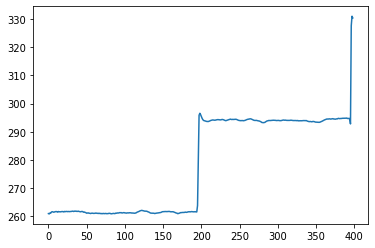

In [2]:
from encoders import Pitch_Extractor
import torch

block_size = 160

extract_f0 = Pitch_Extractor(sample_rate=sr, block_size=block_size)
pitch = extract_f0(torch.tensor(input))
print(len(pitch))
plt.plot(pitch)

In [1]:
from encoders import Loudness_Extractor

n_fft = 2048

extract_vol = Loudness_Extractor(n_fft=2048, sample_rate=sr, block_size=block_size)
vol = extract_vol(torch.tensor(input))
print(len(vol))
plt.plot(vol)

NameError: name 'sr' is not defined

### F0 and Loudness torch ###

In [ ]:
from datasets.dataset_signal import Dataset
import torch
import yaml
from effortless_config import Config

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

sample_rate = config["preprocess"]["sample_rate"]

dataset = Dataset(config)
batch_size = config["hyperparams"]["batch_size"]
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        shuffle=False,
                                        drop_last=False,
                                        )

print("Size of dataset:", len(dataset), "\nSize of sig batch:", next(iter(dataloader)).size())

Synth/synth.wav:   0%|          | 0/1 [00:00<?, ?it/s]/Users/andersbargum/Documents/Python_Code/DDSP-Experiments/datasets/dataset_signal.py:12: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x, sr = li.load(f, sample_rate, mono=True)
Synth/synth.wav: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

Size of dataset: 2 
Size of sig batch: torch.Size([2, 64000])


In [ ]:
class Torch_MFCC_Extractor(torch.nn.Module):
    def __init__(self, n_fft, sample_rate, block_size, device):
        super().__init__()
        self.n_fft = n_fft
        self.sample_rate = sample_rate
        self.block_size = block_size
        self.device = device

        self.mfcc = torchaudio.transforms.MFCC(sample_rate=sample_rate,
                                            n_mfcc=30,
                                            log_mels=True,
                                            melkwargs={"n_fft": self.n_fft, "hop_length": self.block_size, "center": True}
                                            ).to(device)

    def forward(self, sig):
        length = sig.shape[-1] // self.block_size
        mfccs = self.mfcc(sig)
        return mfccs[:, :, :length].permute(0, 2, 1)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "MFCCs")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

torch.Size([2, 400, 30])


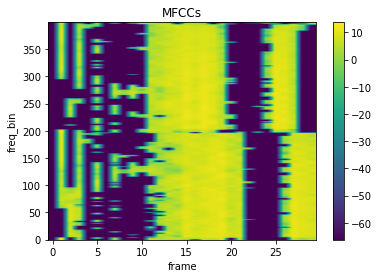

In [ ]:
import matplotlib.pyplot as plt
# from encoders import Torch_Loudness_Extractor, Loudness_Extractor
block_size = 160
n_fft = 1024

mel_extractor = Torch_MFCC_Extractor(n_fft=n_fft, sample_rate=sample_rate, block_size=block_size, device='cpu')

for batch in dataloader:
    mels = mel_extractor(batch)
    print(mels.shape)

plot_spectrogram(mels[0, :, :])

/Users/andersbargum/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


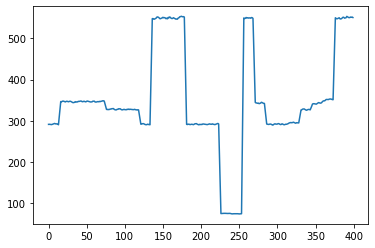

In [ ]:
from encoders import Torch_Pitch_Extractor
block_size = 160

pitch_extractor = Torch_Pitch_Extractor(sample_rate=sample_rate, block_size=block_size)

for batch in dataloader:
    pitch = pitch_extractor(batch)

import matplotlib.pyplot as plt
plt.plot(pitch[0])

In [2]:
from datasets.dataset_all import Dataset, get_files
from effortless_config import Config
import yaml
import torch

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

out_dir = config["preprocess"]["out_dir"]

dataset = Dataset(out_dir)

print(dataset[3]['pitches'].size())

batch_size = config["hyperparams"]["batch_size"]
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        True,
                                        drop_last=True,
)

print("Size of dataset:", len(dataset), "\nSize of sig batch:", next(iter(dataloader))['signals'].size(), "\nSize of sig batch:", next(iter(dataloader))['pitches'].size(), "\nSize of sig batch:", next(iter(dataloader))['loudness'].size())

IndexError: index 3 is out of bounds for axis 0 with size 2

In [ ]:
import numpy as np

f1 = 554
f2 = 125
n = 12 * np.log2(f2/f1)
print(n)

pow(2, n/12) * f1

-25.775494576645215


124.99999999999999

In [ ]:
pow(2, -12/12) * 261.63

130.815

In [2]:
from datasets.dataset_w_embedding import Dataset, get_files
from effortless_config import Config
import yaml
import torch

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

out_dir = config["preprocess"]["out_dir"]

#get_files()

dataset = Dataset(out_dir)

batch_size = config["hyperparams"]["batch_size"]
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        True,
                                        drop_last=False,
)


print("Size of dataset:", len(dataset), "\nSize of sig batch:", next(iter(dataloader))['signals'].size(), "\nSize of sig batch:", next(iter(dataloader))['pitches'].size(), "\nSize of sig batch:", next(iter(dataloader))['loudness'].size(), "\nSize of sig batch:", next(iter(dataloader))['embeddings'].size())

Size of dataset: 2 
Size of sig batch: torch.Size([2, 64000]) 
Size of sig batch: torch.Size([2, 400]) 
Size of sig batch: torch.Size([2, 400]) 
Size of sig batch: torch.Size([2, 256])


In [9]:
import numpy as np
import scipy
import argparse
from pathlib import Path
import torch
import torchaudio.transforms as T

from encoder import inference as encoder
from encoder.audio import preprocess_wav
from encoder.params_model import model_embedding_size as speaker_embedding_size

sample_rate = 16000
mel_window_length = 25 
mel_window_step = 10  
mel_n_channels = 40

mel_spec = T.MelSpectrogram(sample_rate=sample_rate, 
                            n_fft=int(sample_rate * mel_window_length / 1000), 
                            hop_length=int(sample_rate * mel_window_step / 1000),
                            n_mels=mel_n_channels)

# preprocessed_wav = encoder.preprocess_wav(torch.zeros(64000))
# print(preprocessed_wav.shape)

encoder.load_model(Path("saved_models/default/encoder.pt"))
embedding = torch.from_numpy(encoder.embed_utterance(np.zeros(82560)))
print(embedding.shape)


Loaded encoder "encoder.pt" trained to step 1564501
torch.Size([256])
